# 1. Search

*I have moved to the top of the page all of the imports that I will need for this notebook.*

In [1]:
import matplotlib.pyplot as plt
import math

import random
# Methods to use random: https://www.w3schools.com/python/module_random.asp

import copy
# Why we need copy: https://www.programiz.com/python-programming/shallow-deep-copy

## 1.1 The TSP

<img width="50%" src="https://miro.medium.com/v2/resize:fit:1400/1*hBTy3lIoKe22gPyB1e75Jw.png">

For these examples, I need a hard problem. How about the Traveling Salesperson Problem (TSP)? The problem is: given a set of cities, what is the shortest path that will visit all of them, and return home?

First we need a set of cities. I use a dictionary to associate each number of a city with its geographical location:

In [7]:
cities = {0: (60, 200), 1: (180, 200), 2: (80, 180), 3: (140, 180),
          4: (20, 160), 5: (100, 160), 6: (200, 160), 7: (140, 140),
          8: (40, 120), 9: (100, 120), 10: (180, 100), 11: (60, 80),
          12: (120, 80), 13: (180, 60), 14: (20, 40), 15: (100, 40),
          16: (200, 40), 17: (20, 20), 18: (60, 20), 19: (160, 20)}

Let's see where these cities are:

How can we calculate the distance between distance between 2 coordinates
$$distance = \sqrt{({a_0 - b_0})^2 + ({a_1 - b_1})^2}$$

In [11]:
def distance(a, b):
    return math.sqrt((a[0] - b[0]) ** 2 + (a[1] - b[1]) ** 2)

In [13]:
# visualize the tour if we follow the the order of variable "tour"
def plot_tour(tour):
    plt.figure(figsize=(6, 6))
    xy = [cities[i] for i in tour] + [cities[tour[0]]]
    axes = plt.gca()
    axes.set_xlim([0, 200])
    axes.set_ylim([0, 200])
    plt.plot([d[0] for d in xy], [d[1] for d in xy], "-o")

# visualize the locations
def scatter_tour(tour):
    plt.figure(figsize=(6, 6))
    xy = [cities[i] for i in tour] + [cities[tour[0]]]
    axes = plt.gca()
    axes.set_xlim([0, 200])
    axes.set_ylim([0, 200])
    plt.scatter([d[0] for d in xy], [d[1] for d in xy])

# What is the total distance if we follow the order of variable "tour"
def tour_distance(tour):
    total = 0
    current = tour[0]
    for city in tour[1:]:
        total += distance(cities[current], cities[city])
        current = city
    total += distance(cities[tour[-1]], cities[tour[0]])
    return total

In [15]:
tour_distance(range(20))

2004.4899612231877

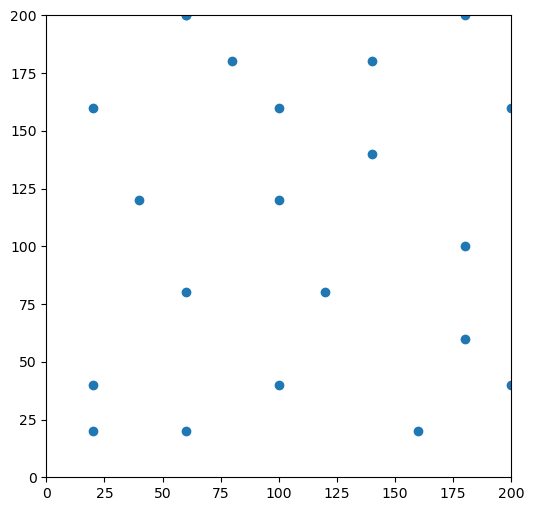

In [17]:
scatter_tour(range(20))

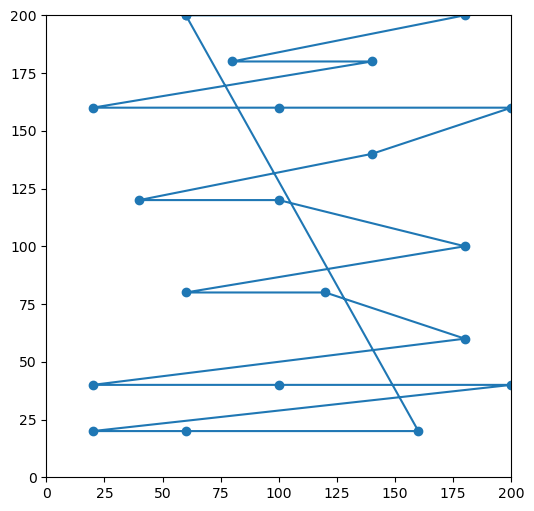

In [19]:
plot_tour(range(20))

How hard is this problem? It turns out that TSP is as hard as they come. We call this **NP hard**. It is very hard because there are so many possibilities, and each new city multiplies those possibilities

For an $n$ city problem, there are factorial($n - 1$) possible routes. Consider just 20 cities.

In [22]:
# Iterative solution:
def factorial(n):
    retval = 1
    for i in range(1, n + 1):
        retval = retval * i
    return retval

# Recursive solution:
def factorial(n):
    if n == 1:
        return 1
    else:
        return n * factorial(n - 1)

In [24]:
factorial(20 - 1)

121645100408832000

To know if we found the shortest, we might have to check all of those. But that is far too many.

## 1.2 Greedy Method

How can we solve this problem of searching for the optimal path? As an example, suppose that you could just pick the closest city to visit at each city. This is called a "greedy" method, because it greedily picks the locally closest.

How good is it?

In [29]:
# the method retuns a array with the order of the cities you want to visit
def greedy_method():
    tour = [0]
    while True:
        min_dist = 100000
        min_city = -1
        for j in range(20):
            if j in tour:
                continue
            dist = distance(cities[tour[-1]], cities[j])
            if dist < min_dist:
                min_dist = dist
                min_city = j
        if min_city == -1:
            break
        tour.append(min_city)
    return tour

In [31]:
greedy_tour = greedy_method()
greedy_tour

[0, 2, 5, 9, 7, 3, 1, 6, 10, 13, 16, 19, 15, 12, 11, 8, 4, 14, 17, 18]

In [33]:
tour_distance(greedy_tour)

1064.3934369990914

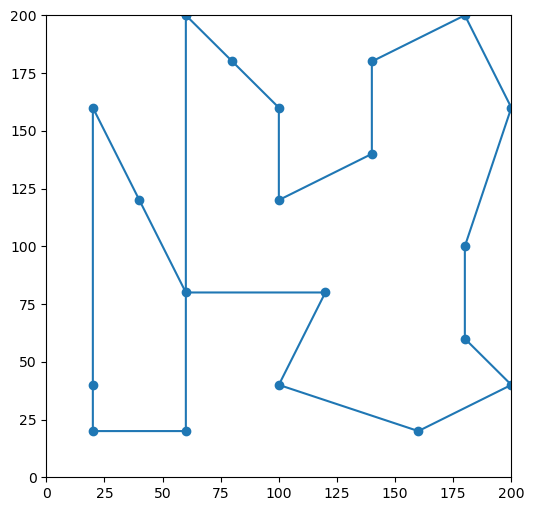

In [35]:
plot_tour(greedy_tour)

Not too bad, but we can do better. Ok, let's try some other algorithms.

## 1.3 Guess and Step

Let's consider a simple method of problem solving: **guess and step**. First, just make a guess and note how close you are to a solution. Next, pick some piece of your guess and consider a slight change. If the variation is worse, don't make the change. If the variation is better, go ahead make the change. Now, continue making slight changes until you get a good enough solution. We will need:

* a method of representing a problem (e.g., a **tour**)
* a measure of how good the guess is (e.g., a **fitness score**)
* a method of making slight changes (e.g., **mutation**)

Let's explore an iterative guess-and-check algorithm.

We need a method for creating random "tours":

In [37]:
# create a random tour
def make_tour():
    ret_list = []
    for i in range(len(cities)):
        city = random.choice(range(len(cities)))
        while city in ret_list:
            city = random.choice(range(len(cities)))
        ret_list.append(city)
    return ret_list

In [39]:
guess = make_tour()
guess

[2, 15, 13, 10, 16, 4, 3, 9, 0, 8, 1, 14, 7, 18, 5, 12, 19, 6, 11, 17]

In [41]:
tour_distance(guess)

2447.0933646652725

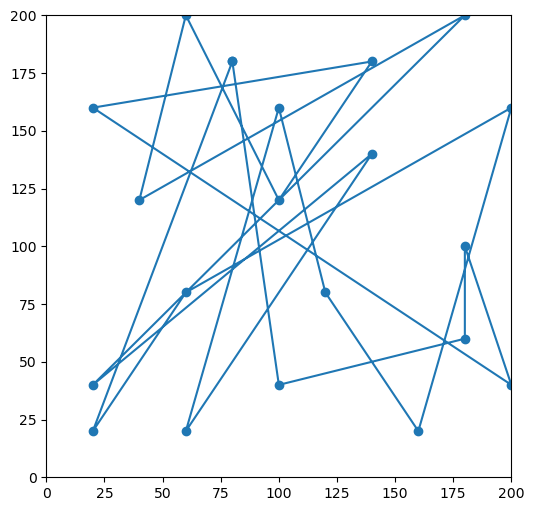

In [43]:
plot_tour(guess)

And we need a method for measure a tour's "fitness". We'll use "total distance".

In [46]:
def fitness(tour):
    return tour_distance(tour)

In [48]:
fitness(greedy_tour)

1064.3934369990914

In [50]:
fitness(guess)

2447.0933646652725

Finally, we need a method of mutating a tour. Tours aren't just random numbers: they are a circuit. For this problem, we'll use a specialized mutation function that just swaps two cities. That way it will always be a valid circuit.

In [53]:
def mutate(tour):
    tour = copy.copy(tour)
    # Pick two points and swap:
    point1 = random.randint(0, len(cities) - 1)
    point2 = random.randint(0, len(cities) - 1)
    tour[point1], tour[point2] = tour[point2], tour[point1]
    return tour

In [55]:
print(guess)
guess = mutate(guess)
print(guess)

[2, 15, 13, 10, 16, 4, 3, 9, 0, 8, 1, 14, 7, 18, 5, 12, 19, 6, 11, 17]
[2, 1, 13, 10, 16, 4, 3, 9, 0, 8, 15, 14, 7, 18, 5, 12, 19, 6, 11, 17]


Now, let's iteratively mutate the guess, and ignore it if it is worse, but replace the original guess if the mutation is better.

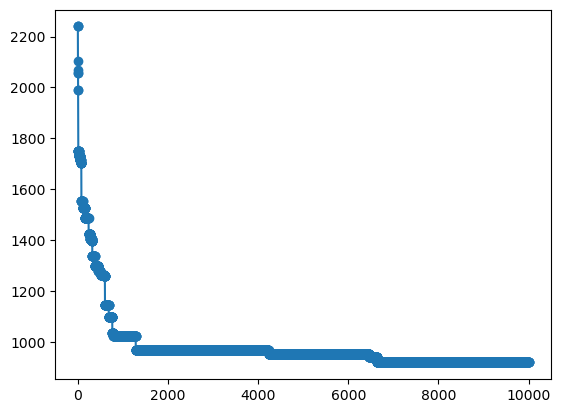

<Figure size 640x480 with 0 Axes>

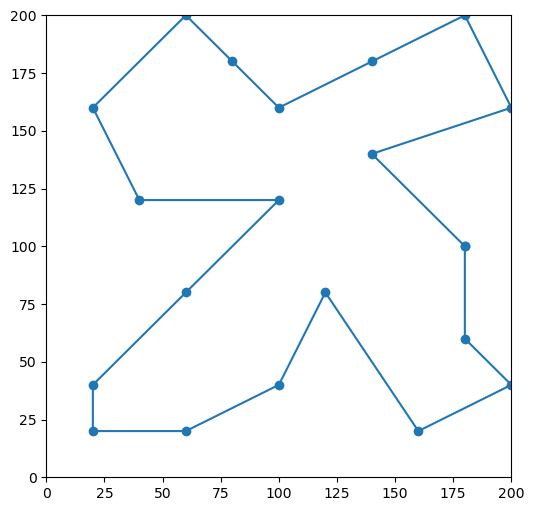

In [58]:
guess = make_tour()
fit_list = [fitness(guess)]

for i in range(10000):
    new_guess = copy.copy(guess)
    for j in range(2):
        new_guess = mutate(new_guess)
    f1 = fitness(guess)
    f2 = fitness(new_guess)
    if f2 < f1:
        fit_list.append(f2)
        guess = new_guess
    else:
        fit_list.append(f1)
        
        
plt.plot(fit_list, marker="o")
plt.figure()
plot_tour(guess)

In [60]:
guess, fitness(guess)

([10, 13, 16, 19, 12, 15, 18, 17, 14, 11, 9, 8, 4, 0, 2, 5, 3, 1, 6, 7],
 919.5330792846987)

That's not too bad! Perhaps a bit better than the greedy method used. 

## 1.4 Hill Climbing

This guess-and-step methodology is actually called *hill climbing* due to the following metaphor. Start at a random place on a hill. Pick a direction to step. If the place you would step to is higher than where you are, make the step, otherwise stay where you are. This little algorithm will eventually take you to the top of the hill. However, it might might not take you to the highest place around (*Local Maximum*) because you could get trapped on a little plateau (i.e., you would have to step to a lower place before stepping to even higher ground (*Global Maximum*) ).

<img width="70%" src="https://d1m75rqqgidzqn.cloudfront.net/wp-data/2020/04/04151652/Annotation-2020-04-04-151529.jpg">

In [66]:
def hillclimb(times):
    guess = make_tour()
    fit_list = [fitness(guess)]

    for i in range(times):
        new_guess = mutate(guess)
        f1 = fitness(guess)
        f2 = fitness(new_guess)
        if f2 < f1:
            fit_list.append(f2)
            guess = new_guess
        else:
            fit_list.append(f1)
    plt.plot(fit_list, marker="o")
    plt.figure()
    plot_tour(guess)
    return guess, fitness(guess)

([0, 1, 6, 3, 2, 5, 9, 7, 10, 13, 16, 19, 12, 15, 18, 17, 14, 11, 8, 4],
 994.680265542313)

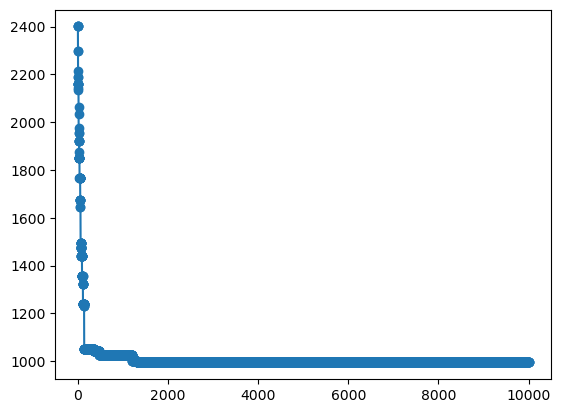

<Figure size 640x480 with 0 Axes>

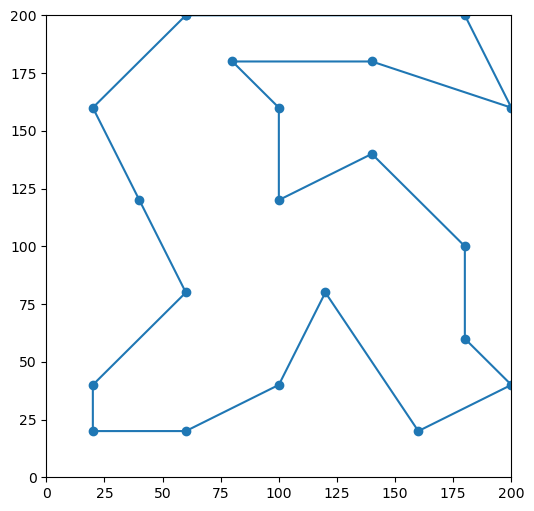

In [68]:
hillclimb(10000)

In [70]:
fit_list[-1]

919.5330792846987

## 1.5 Random Search

One solution to getting stuck on a plateau is to make random moves. If you do that all of the time, that is called "random search".

In [74]:
def random_search(times):
    guess = make_tour()
    fit_list = [fitness(guess)]

    for i in range(times):
        new_guess = mutate(guess)
        f1 = fitness(guess)
        f2 = fitness(new_guess)
        if random.random() > .5:
            fit_list.append(f2)
            guess = new_guess
        else:
            fit_list.append(f1)
    plt.plot(fit_list, marker="o")
    plt.figure()
    plot_tour(guess)
    return guess, fitness(guess)

([0, 9, 17, 14, 13, 6, 3, 2, 5, 11, 15, 7, 8, 19, 12, 1, 18, 4, 10, 16],
 2179.099437902027)

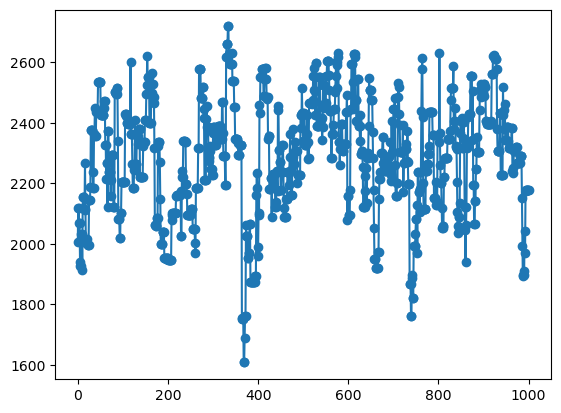

<Figure size 640x480 with 0 Axes>

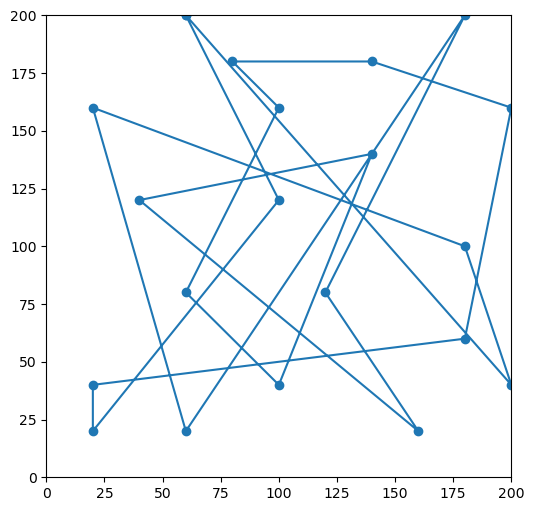

In [76]:
random_search(1000)

## 1.6 Simulated Annealing

A slightly better version of hill climbing allows you to take random steps sometimes, regardless of whether or not the step would put you on higher ground. Of course, you don't always want to take random steps (that's called *random search*), so you'll need to control your randomness. If you only take random steps as dictated by a schedule, then you are using *simulated annealing*. Simulated annealing allows you to start off taking random steps quite often, but then slowly curb the habit. This works better than hill climbing when the ground is fairly smooth.

In [80]:
def simulated_annealing(times):
    guess = make_tour()
    fit_list = [fitness(guess)]

    for i in range(times):
        new_guess = mutate(guess)
        f1 = fitness(guess)
        f2 = fitness(new_guess)
        if random.random() > i/times:
            # Pick random:
            if random.random() < .5:
                fit_list.append(f1)  
            else:
                fit_list.append(f2)
                guess = new_guess
        elif f2 < f1:
            fit_list.append(f2)
            guess = new_guess
        else:
            fit_list.append(f1)
    plt.plot(fit_list, marker="o")
    plt.figure()
    plot_tour(guess)
    return guess, fitness(guess)

([8, 11, 14, 17, 18, 15, 1, 6, 10, 13, 16, 19, 12, 9, 7, 3, 5, 2, 0, 4],
 1010.0027920448301)

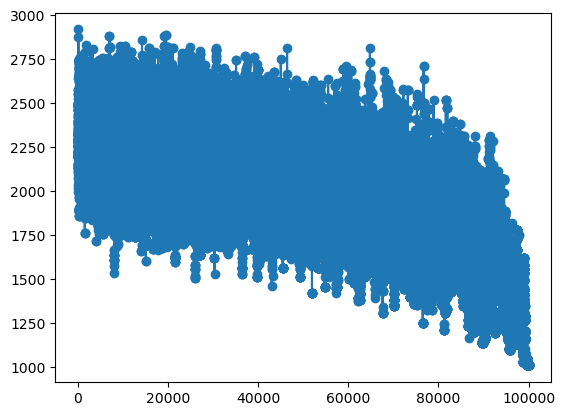

<Figure size 640x480 with 0 Axes>

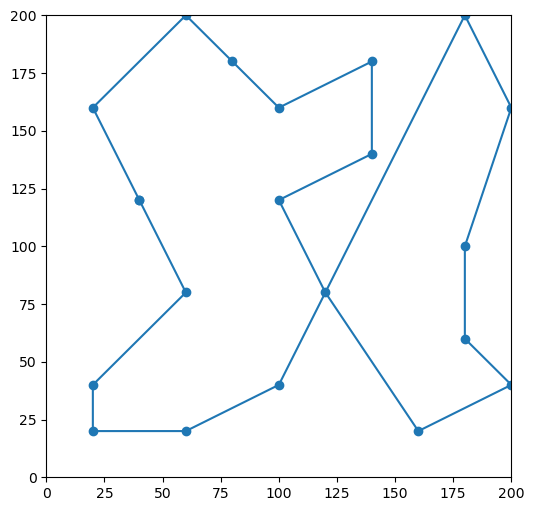

In [82]:
simulated_annealing(100000)